In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.preprocessing import minmax_scale
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
# !wget -P ./data https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [3]:
SEED = 1

In [4]:
DATA_PATH = './data/AER_credit_card_data.csv'

In [5]:
df = pd.read_csv(DATA_PATH)
df.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5


## Data preparation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [7]:
target_col = 'card'
numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical = ['owner', 'selfemp']

In [8]:
target = (df[target_col] == 'yes').astype(int)

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

target_full_train = (df_full_train[target_col] == 'yes').astype(int)
target_train = (df_train[target_col] == 'yes').astype(int)
target_val = (df_val[target_col] == 'yes').astype(int)
target_test = (df_test[target_col] == 'yes').astype(int)

df_full_train.drop(columns=target_col, inplace=True)
df_train.drop(columns=target_col, inplace=True)
df_val.drop(columns=target_col, inplace=True)
df_test.drop(columns=target_col, inplace=True)

df_full_train = df_full_train[numerical + categorical]
df_train = df_train[numerical + categorical]
df_val = df_val[numerical + categorical]
df_test = df_test[numerical + categorical]
len(df_train), len(df_val), len(df_test)

(791, 264, 264)

## Question 1

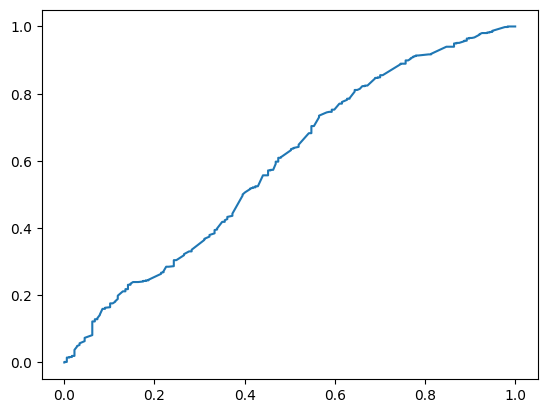

In [10]:
# Test
fpr, tpr, t = roc_curve(target_train, df_train['income']) 
plt.plot(fpr, tpr);

In [11]:
invert_features = ['reports', 'age', 'dependents', 'months']
auc_scores = {}
for feature in numerical:
    inversion = 1
    if feature in invert_features:
        inversion = -1
    fpr, tpr, t = roc_curve(target_train, inversion * df_train[feature])
    auc_scores[feature] = auc(fpr, tpr)

In [12]:
auc_scores

{'reports': 0.7166629860689376,
 'age': 0.5240020979407055,
 'income': 0.5908049467233478,
 'share': 0.989183643423692,
 'expenditure': 0.991042345276873,
 'dependents': 0.5327757227773791,
 'months': 0.5294217780967629,
 'majorcards': 0.5343859842838476,
 'active': 0.6043173411362006}

## Question 2

In [13]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=SEED)

In [15]:
model.fit(X_train, target_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

In [16]:
y_val_pred = model.predict_proba(X_val)[:, 1]

In [17]:
roc_auc_score(target_val, y_val_pred)

0.995171242063847

## Question 3

In [18]:
step = 0.01
n_steps = int((1 - 0) / step)
n_steps

100

In [19]:
ts = np.linspace(0, 1, n_steps+1)
pr =  np.empty(n_steps + 1)
rc =  np.empty(n_steps + 1)
for i, t in enumerate(ts):
    ((tn, fp),
     (fn, tp)) = confusion_matrix(target_val, y_val_pred >= t)
    pr[i] = tp / (fp + tp)
    rc[i] = tp / (fn + tp)

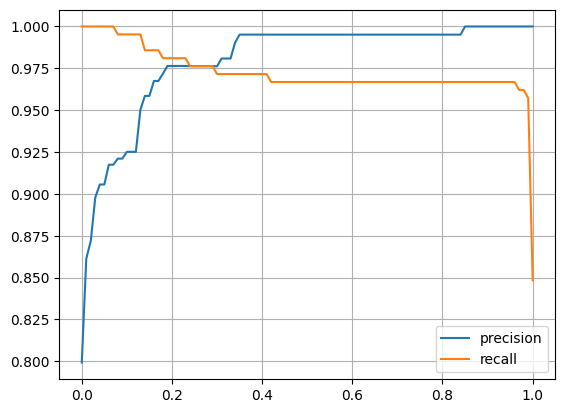

In [20]:
# pr, rc, ts = precision_recall_curve(target_val, y_val_pred)
plt.plot(ts, pr, label='precision')
plt.plot(ts, rc, label='recall')
plt.legend()
plt.grid()

## Question 4

In [21]:
f1 = 2 * pr * rc / (pr + rc)

In [22]:
ts[f1.argmax()]

0.35000000000000003

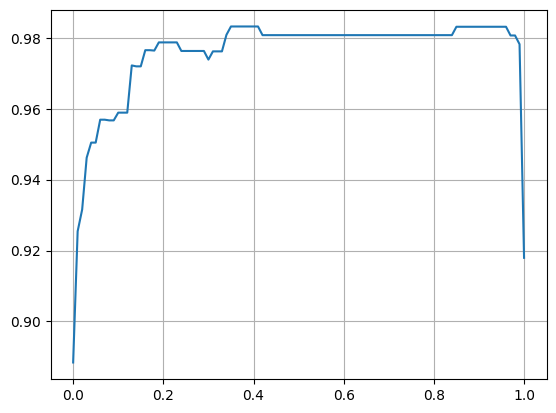

In [23]:
plt.plot(ts, f1)
plt.grid()

## Question 5

In [24]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=SEED)
    model.fit(X_train, y_train)
    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [28]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = target_full_train.iloc[train_idx].values
    y_val = target_full_train.iloc[val_idx].values
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.996 +- 0.003


## Question 6

In [29]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = target_full_train.iloc[train_idx].values
        y_val = target_full_train.iloc[val_idx].values
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.996 +- 0.003
C=0.1 0.996 +- 0.003
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003
